In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

In [30]:
# import master dataframe
master_df = pd.read_csv('data/master_df.csv')

# drop rows with NaN
master_df.dropna(how='any',axis=0, inplace=True) 

# drop index
master_df.drop(master_df.columns[0], axis=1, inplace=True)

# one hot encode days of the week, month
master_df = pd.get_dummies(master_df, columns=['DAY_OF_WEEK','MONTH'])

In [11]:
master_df.UCR_PART.value_counts()

Part Three    198363
Part Two      121483
Part One       77225
Name: UCR_PART, dtype: int64

In [10]:
# split into predictors and response
X = master_df.drop(['OFFENSE_CODE_GROUP','UCR_PART','OFFENSE_DESCRIPTION'], axis=1) 
y = master_df['OFFENSE_CODE_GROUP']

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [11]:
# fit logistic regression
logreg = LogisticRegression(C=100000, fit_intercept=True, solver='lbfgs')
logreg.fit(X_train.values, y_train.values);

In [12]:
accuracy_score(logreg.predict(X_train), y_train)

0.10383559573878662

In [6]:
pd.Series(logreg.predict(X_train)).value_counts()

Part Three    198161
dtype: int64

In [7]:
y_train.value_counts()

Part Three    99081
Part Two      60601
Part One      38479
Name: UCR_PART, dtype: int64

## Decision Trees

In [8]:
depths = list(range(1, 21))

def calc_meanstd(X_train, y_train, depths):

    # store output variables
    cvmeans      = []
    cvstds       = []
    train_scores = []
    
    # test different tree depths
    for depth in depths:
        
        # create model
        dtree = DecisionTreeClassifier(max_depth=depth)
        
        # use k=5 cross validation to evaluate performance
        cv_scores = cross_val_score(dtree, X_train, y_train, cv=5)
        
        # store mean and std of cv scores
        cvmeans.append(np.mean(cv_scores))
        cvstds.append(np.std(cv_scores))
    
        # evaluate performance on training set
        dtree.fit(X_train,y_train)
        y_pred_train = dtree.predict(X_train)
        acc_score_train = accuracy_score(y_pred_train, y_train)
        train_scores.append(acc_score_train)
    
    # end of your code here
    return cvmeans, cvstds, train_scores

In [9]:
cvmeans, cvstds, train_scores = calc_meanstd(X_train, y_train, depths)

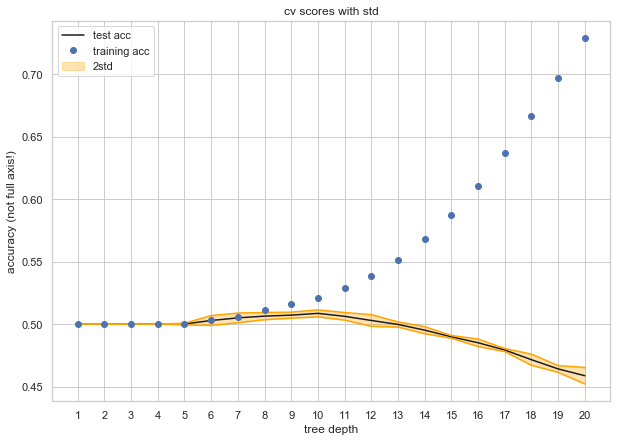

In [12]:
# initialize figure
fig = plt.figure(figsize=(10,7))

# get data for mean +/- 2std
stdabove = np.array(cvmeans) + 2*np.array(cvstds)
stdbelow = np.array(cvmeans) - 2*np.array(cvstds)

# plot cvmeans and cvstds
plt.plot(cvmeans,'k',label='test acc')
plt.plot(stdabove,'orange')
plt.plot(stdbelow,'orange')

# fill in between space
plt.fill_between(range(len(cvmeans)),stdbelow,stdabove,color='orange',alpha=.3,label='2std')

# plot training scores
plt.plot(train_scores,'o',label='training acc')

# plot formatting
plt.title('cv scores with std')
plt.xlabel('tree depth')
# plt.ylim(0.54,0.7) # can set the y-axis to focus on the cross-validation performance
plt.xticks(range(0,20),range(1,21))
plt.ylabel('accuracy (not full axis!)')
plt.legend()
plt.show()

## Random Forest

In [31]:
X = master_df.drop(['OFFENSE_CODE_GROUP','UCR_PART','OFFENSE_DESCRIPTION','SHOOTING'], axis=1)
y = master_df['UCR_PART']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
rf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42).fit(X_train, y_train)

In [ ]:
pd.Series(rf.predict(X_test)).value_counts()

issues with RF: predicts much more URC than the percentage in the dataset (92% vs 50%)

looking to predict something useful, like crime density per area, but the crimes dont seem to correlate with area at all

rf with max_depth 20 has train acc 70% and test acc 51%
rf with max_depth  8 has train acc 50% and test acc 50%
rf with max_depth 40 has train acc 99% and test acc 51%

feature engineering, think about 
make different random forests 
try that matrix of correlation thing
max depth and number of trees and look up other regularixation for random forest
take log for property value because its so skewed
google feature engineering specific to each column


In [ ]:
pd.Series(rf.predict(X_test)).value_counts()
y_test.value_counts()[0] / sum(y_test.value_counts())

In [47]:
rf.predict_proba(X_test)

array([[0.24833333, 0.45166667, 0.3       ],
       [0.15671714, 0.39372676, 0.44955609],
       [0.07188889, 0.51930556, 0.40880556],
       ...,
       [0.17875   , 0.55375   , 0.2675    ],
       [0.12      , 0.55941176, 0.32058824],
       [0.15      , 0.635     , 0.215     ]])

In [45]:
accuracy_score(rf.predict(X_test), y_test)

0.5149405024239753

In [46]:
accuracy_score(rf.predict(X_train), y_train)

0.9939368373334676

In [26]:
km = KMeans(100).fit(X_train[['Lat', 'Long']])
y_train_pred = km.predict(X_train[['Lat', 'Long']])

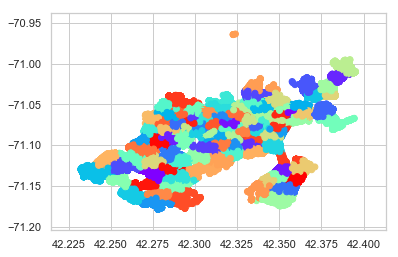

In [27]:
plt.scatter(X_train['Lat'],X_train['Long'], c=km.labels_, cmap='rainbow')

In [28]:
km.labels_

array([26, 56, 94, ..., 24,  3,  1], dtype=int32)

In [77]:
offences = master_df.OFFENSE_DESCRIPTION.value_counts()

offences.to_csv('data/list_of_offences.csv')

In [76]:
offences

SICK/INJURED/MEDICAL - PERSON                      25100
INVESTIGATE PERSON                                 23760
M/V - LEAVING SCENE - PROPERTY DAMAGE              19328
VANDALISM                                          19054
ASSAULT SIMPLE - BATTERY                           18718
VERBAL DISPUTE                                     17550
INVESTIGATE PROPERTY                               14429
TOWED MOTOR VEHICLE                                14224
THREATS TO DO BODILY HARM                          11895
LARCENY THEFT FROM BUILDING                        11724
PROPERTY - LOST                                    11669
LARCENY THEFT FROM MV - NON-ACCESSORY              10802
LARCENY SHOPLIFTING                                10423
WARRANT ARREST                                     10036
LARCENY ALL OTHERS                                  7781
M/V ACCIDENT - PROPERTY  DAMAGE                     7335
MISSING PERSON - LOCATED                            6343
ASSAULT - AGGRAVATED - BATTERY 

log of skewed
make our own categories

DROP crimes labeled "OTHER"


